# Embedding Drift Analysis

This notebook shows how to perform simple drift detection on embedding vectors. This will help detect changes in the underlying reference data used in the RAG pattern.

## Method

Embedding vectors represent an item in n-dimensional space. `n` is often large; Bedrock's Titan embedding model creates vectors of size 4096. We will start by performing dimension reduction using PCA. Then we'll use KMeans to identify a set of cluster centers.

We'll calculate the following information to set a baseline:

* The number of dimensions in PCA that explain 95% of the variance
* The location of each cluster centroid
* The proportion of samples in each cluster
* Inertia (sum of squared distances to cluster centroids)
* The silhouette score, which ranges from `-1` to `1`. 

According to the [documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html#pyspark.ml.evaluation.ClusteringEvaluator.metricName) about the silhouette score:

    The Silhouette is a measure for the validation of the consistency within clusters. It ranges between 1 and -1, where a value close to 1 means that the points in a cluster are close to the other points in the same cluster and far from the points of the other clusters.

When we want to compare a newer set of embeddings, we'll compute a new baseline. Then we'll compare:

* Change in number of dimensions in PCA that explain 95% of the variance
* How far the cluster centroids have moved
* Change in proportion of samples in each cluster
* Change in inertia
* Change in silhouette score

## Read latest baseline

In [9]:
import boto3
tbl = 'CdkStack-DriftTableB5DFD1A9-HWAWAHRFLML1'
ddbclient = boto3.client('dynamodb')

In [37]:
response = ddbclient.query(
    ExpressionAttributeValues={
        ':v1': {
            'S': 'BASELINE',
        },
    },
    KeyConditionExpression='jobtype = :v1',
    TableName=tbl,
    Select='ALL_ATTRIBUTES',
    ConsistentRead=False,
    Limit=1,
    ScanIndexForward=False
)

In [38]:
response['Items']

[{'inertia': {'N': '16388.649121501876'},
  'clustersizes': {'S': '[11, 19, 12, 5, 2, 14, 8, 16, 1, 3]'},
  'varpc': {'N': '61'},
  'score': {'N': '0.09424582322489648'},
  'jobdate': {'N': '1689611647'},
  'jobtype': {'S': 'BASELINE'}}]

In [39]:
import json
baseline_item = response['Items'][0]
baseline = {
    'score': float(baseline_item['score']['N']),
    'varpc': float(baseline_item['varpc']['N']),
    'inertia': float(baseline_item['inertia']['N']),
    'clustersizes': json.loads(baseline_item['clustersizes']['S']),
    'centers': {}
}

In [40]:
baseline

{'score': 0.09424582322489648,
 'varpc': 61.0,
 'inertia': 16388.649121501876,
 'clustersizes': [11, 19, 12, 5, 2, 14, 8, 16, 1, 3],
 'centers': {}}

In [41]:
c_tbl = 'CdkStack-DriftTableCentroids101B69BE-1QNK6IRY56BQ'
jobdate = response['Items'][0]['jobdate']['N']
c_response = ddbclient.query(
            ExpressionAttributeValues={
                ':v1': {
                    'S': f'BASELINE-{jobdate}',
                },
            },
            KeyConditionExpression='jobtypedate = :v1',
            TableName=c_tbl,
            Select='ALL_ATTRIBUTES',
            ConsistentRead=False,
            ScanIndexForward=False
        )

In [42]:
c_response['Items']

[{'jobtypedate': {'S': 'BASELINE-1689611647'},
  'centroid': {'N': '9'},
  'center': {'S': '0.23567708333333331,-0.06608072916666666,0.0938720703125,0.3958333333333333,-0.17692057291666666,-0.2265625,0.4912109375,0.24015299479166666,-0.068115234375,-0.41178385416666663,0.15364583333333331,-0.22526041666666666,-0.023984273274739582,0.013346354166666666,-0.5045572916666666,-0.103515625,-0.6595052083333333,0.22639973958333331,0.15437825520833331,0.28125,-0.20072428385416666,-0.2737630208333333,0.21988932291666666,0.5950520833333333,0.162109375,-0.13151041666666666,-0.14339192708333331,0.28125,-0.047159830729166664,0.053385416666666664,0.07242838541666666,0.1201171875,0.09521484375,0.01806640625,0.20194498697916666,0.101806640625,-0.00927734375,-0.15934244791666666,-0.017537434895833332,-0.1011975606282552,0.4580078125,-0.0537109375,-0.10493977864583333,-0.6490885416666666,0.023600260416666664,-0.08561197916666666,0.2998046875,-0.13509114583333331,0.07503255208333333,-0.208984375,0.2210286

In [49]:
for c_item in c_response['Items']:
    centroid = int(c_item['centroid']['N'])
    center = c_item['center']['S']
    center = center.split(',')
    center = [float(x) for x in center]
    baseline['centers'][centroid] = center

In [50]:
baseline

{'score': 0.09424582322489648,
 'varpc': 61.0,
 'inertia': 16388.649121501876,
 'clustersizes': [11, 19, 12, 5, 2, 14, 8, 16, 1, 3],
 'centers': {9: [0.23567708333333331,
   -0.06608072916666666,
   0.0938720703125,
   0.3958333333333333,
   -0.17692057291666666,
   -0.2265625,
   0.4912109375,
   0.24015299479166666,
   -0.068115234375,
   -0.41178385416666663,
   0.15364583333333331,
   -0.22526041666666666,
   -0.023984273274739582,
   0.013346354166666666,
   -0.5045572916666666,
   -0.103515625,
   -0.6595052083333333,
   0.22639973958333331,
   0.15437825520833331,
   0.28125,
   -0.20072428385416666,
   -0.2737630208333333,
   0.21988932291666666,
   0.5950520833333333,
   0.162109375,
   -0.13151041666666666,
   -0.14339192708333331,
   0.28125,
   -0.047159830729166664,
   0.053385416666666664,
   0.07242838541666666,
   0.1201171875,
   0.09521484375,
   0.01806640625,
   0.20194498697916666,
   0.101806640625,
   -0.00927734375,
   -0.15934244791666666,
   -0.017537434895833

## Read latest snapshot

In [52]:
response = ddbclient.query(
    ExpressionAttributeValues={
        ':v1': {
            'S': 'SNAPSHOT',
        },
    },
    KeyConditionExpression='jobtype = :v1',
    TableName=tbl,
    Select='ALL_ATTRIBUTES',
    ConsistentRead=False,
    Limit=1,
    ScanIndexForward=False
)

In [53]:
snapshot_item = response['Items'][0]
snapshot = {
    'score': float(snapshot_item['score']['N']),
    'varpc': float(snapshot_item['varpc']['N']),
    'inertia': float(snapshot_item['inertia']['N']),
    'clustersizes': json.loads(snapshot_item['clustersizes']['S']),
    'centers': {}
}

In [54]:
jobdate = response['Items'][0]['jobdate']['N']
c_response = ddbclient.query(
            ExpressionAttributeValues={
                ':v1': {
                    'S': f'SNAPSHOT-{jobdate}',
                },
            },
            KeyConditionExpression='jobtypedate = :v1',
            TableName=c_tbl,
            Select='ALL_ATTRIBUTES',
            ConsistentRead=False,
            ScanIndexForward=False
        )

In [55]:
for c_item in c_response['Items']:
    centroid = int(c_item['centroid']['N'])
    center = c_item['center']['S']
    center = center.split(',')
    center = [float(x) for x in center]
    snapshot['centers'][centroid] = center

## Compare snapshot to baseline

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")

### Inertia, silhouette score, and 95% variation dimension size

In [59]:
import pandas as pd
df = pd.DataFrame({
    'Type': ['baseline', 'snapshot', 'delta'],
    '95% variation': [baseline['varpc'], snapshot['varpc'], snapshot['varpc'] - baseline['varpc']],
    'Inertia': [baseline['inertia'], snapshot['inertia'], snapshot['inertia'] - baseline['inertia']],
    'Silhouette score': [baseline['score'], snapshot['score'], snapshot['score'] - baseline['score']]
})

In [61]:
df

,Type,95% variation,Inertia,Silhouette score
0,baseline,61.0,16388.649122,0.094246
1,snapshot,100.0,162528.921208,0.093461
2,delta,39.0,146140.272087,-0.000785


### Proportion of samples in each cluster

In [63]:
import numpy as np
bClusters = np.asarray(baseline['clustersizes'])
sClusters = np.asarray(snapshot['clustersizes'])
dfProportions = pd.DataFrame({
    'cluster': [idx for idx in range(10)],
    'baseline': bClusters / bClusters.sum(),
    'snapshot': sClusters / sClusters.sum()
})

In [69]:
dfProportionsPlot = dfProportions.melt('cluster', var_name='type', value_name='proportions')

Text(0.5, 1.0, 'Proportion of samples in each cluster')

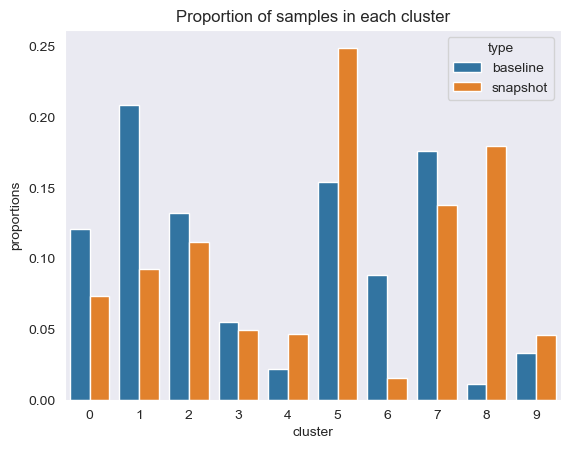

In [74]:
sns.barplot(data=dfProportionsPlot, x="cluster", y="proportions", hue="type") 
plt.title("Proportion of samples in each cluster")

### Movement of cluster centroids

In [75]:
distances = []
for idx in range(10):
    c1 = np.asarray(baseline['centers'][idx])
    c2 = np.asarray(snapshot['centers'][idx])
    distance = np.linalg.norm(c2-c1)
    distances.append(distance)

In [76]:
dfDistance = pd.DataFrame({
    'cluster': [idx for idx in range(10)],
    'distance': distances
})
dfDistance

,cluster,distance
0,0,17.442452
1,1,8.187957
2,2,19.790791
3,3,16.687752
4,4,21.327555
5,5,14.555464
6,6,17.796029
7,7,16.544616
8,8,25.786652
9,9,16.741785
